In [6]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import matplotlib.ticker as mticker

import MN_Thesis_Package.NetworkClasses.Linear_Layers_and_Networks as LLN
from MN_Thesis_Package.utils.main_training_loop import train
# from MN_Thesis_Package.utils import ModelHandler as MH
from MN_Thesis_Package.utils import conv_to_linear_comparable as convert

In [ ]:
# TODO: eliminate this transform and add batchnorm as the first layer for each network
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10_train = datasets.CIFAR10('data/', download=True, transform=transform, train=True)
cifar10_test = datasets.CIFAR10('data/', download=True, transform=transform, train=False)

train_loader = torch.utils.data.DataLoader(cifar10_train,
                                           batch_size=128,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar10_test,
                                          batch_size=128,
                                          shuffle=False)

x_typical = None
input_shape = None
for x_train, y_train in train_loader:
    x_typical = x_train.cuda(non_blocking=True)
    input_shape = x_typical.shape
    break

input_channels, input_width, input_height = input_shape[1:]
input_size_flattened = input_channels*input_width*input_height
n_classes = 10

In [ ]:
# for n_layers in np.linspace(1, 74, 8).astype(int):
n_layers = 19

block_dimensions = np.logspace(6, 9, n_layers, base=2).astype(int).tolist()
block_dimensions = sorted(block_dimensions + block_dimensions)
n_parameters = convert.n_parameters_conv(block_dimensions, input_shape[1:], n_classes, bias=False)

linear_output_sizes, linear_n_parameters = convert.linear_hidden_layers_from_target_n_parameters(n_parameters,
                                                                                                 np.product(input_shape[1:]),
                                                                                                 n_classes)

block_dimensions = [input_channels] + block_dimensions
print(f'\n{2 * n_layers + 2}:')
print(f'    conv:\n        channels: {block_dimensions}\n        # parameters: {n_parameters}'
      + f'\n        total parameters: {np.sum(n_parameters):,}')
print(f'    linear:\n        output_size: {linear_output_sizes}\n        # parameters {linear_n_parameters}'
      + f'\n        total parameters: {np.sum(linear_n_parameters):,}')

if 2 * n_layers + 2 == 150:
    plt.plot(block_dimensions)
    plt.show()

In [ ]:
linear_output_sizes = [size // 2 * 2 for size in linear_output_sizes]
print(linear_output_sizes)
model = LLN.LinearNet(input_size_flattened, linear_output_sizes, num_classes=10,
                      out_f=nn.LogSoftmax(dim=1),
                      layer_class=LLN.LooksLinearLayer,
                      norm_type='batchnorm').cuda()

# call cuda prior to constructing the optimizer or enabling opacus
model.cuda()
# model.enable_opacus()
model_handler = MH.ModelHandler(model=model,
                                loss_function=nn.NLLLoss(),
                                optimizer=torch.optim.SGD(model.parameters(), lr=1e-3),
                                mask_sizes=[],
                                num_classes=n_classes)

In [ ]:
model_handler.set_metric_settings(conditioning_x=False, input_grad_rank_x=False,
                                  weight_grad_rank_x=False, coherence_x=False,
                                  confusion_x_samples=0, diversity_x_samples=0,
                                  conditioning_w=False, confusion_w=False,
                                  diversity_w=False, coherence_w=False)

In [ ]:
def calculate_paired_weight_statistics(crelu_model, tol=1e-3):
    results_dict = dict()
    # generate statistics about paired weight distances
    for name, layer in crelu_model.named_modules():
        if isinstance(layer, LLN.CReLULinearLayer) or isinstance(layer, LLN.LooksLinearLayer) or isinstance(layer, LLN.OrthoLinear):
            m, n = layer.weight.shape

            with torch.no_grad():
                distances = torch.abs(layer.weight[:, :n // 2] + layer.weight[:, - n // 2:])

                results_dict[name] = dict()
                results_dict[name]['median absolute pairwise distance'] = torch.median(distances).item()
                results_dict[name]['%_pairs_less_than_tol_apart'] = np.sum(distances.cpu().numpy() < tol) / np.product(distances.shape)
                results_dict[name]['mean absolute pairwise distance'] = torch.mean(distances).item()

    return results_dict

In [ ]:
results = dict()

In [ ]:
max_epochs = 10

results[0] = calculate_paired_weight_statistics(model_handler.model)

for epoch in range(max_epochs):
    train(model_handler, epoch+1, train_loader, test_loader, sample_every=None)
    results[epoch+1] = calculate_paired_weight_statistics(model_handler.model)

In [2]:
import torch

In [8]:
network_name = 'LooksLinear_40'
# torch.save(results, f'pairwise_distance_results/{network_name}.paired_distances_results')
results = torch.load(f'pairwise_distance_results/{network_name}.paired_distances_results')
max_epochs = 10

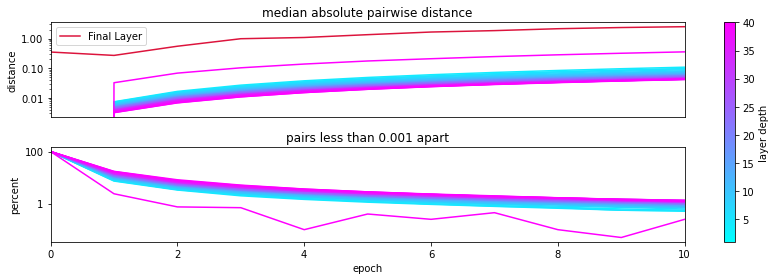

In [10]:
# plot results
import tikzplotlib

n_layers = len(results[0].keys())
cmap = cm.cool
c_norm = colors.Normalize(vmin=1, vmax=n_layers-1)

options = ['median absolute pairwise distance', '%_pairs_less_than_tol_apart']

fig, ax = plt.subplots(len(options), 1)
fig.set_figwidth(12)
fig.set_figheight(4)
fig.set_facecolor('white')

for k, metric in enumerate(options):
    if metric in ['%_pairs_less_than_tol_apart']:
        title_str = f'pairs less than {1e-3} apart'
        percent_correction = 100
    else:
        title_str = metric
        percent_correction = 1

    for i, layer_name in enumerate(results[0].keys()):
        y = [percent_correction * results[epoch][layer_name][metric] for epoch in results.keys()]
        x = [epoch for epoch in results.keys()]

        if i == n_layers - 1:
            ax[k].semilogy(x, y, color='crimson', label='Final Layer')
        else:
            ax[k].semilogy(x, y, color=cmap((i+1)/(n_layers-2)))

    ax[k].set_title(title_str.replace(r'%', r'/%'))
    ax[k].set_xlim(0, max_epochs)
    # ax[k].legend()
    ax[k].yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax[k].yaxis.get_major_formatter().set_scientific(False)
ax[0].set_ylabel('distance')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('percent')
ax[0].legend()
# ax[0].get_xaxis().set_visible(False)
ax[0].set_xticks([])

plt.tight_layout()
fig.colorbar(cm.ScalarMappable(norm=c_norm, cmap=cmap), ax=ax.ravel().tolist(), label='layer depth')
plt.savefig('plots/pairwise_distance_results.pdf', bbox_inches='tight', dpi=3000)
plt.show()
# tikzplotlib.save(f'plots/paired_weights-{network_name}.tex',
#                  axis_width="6.5in", axis_height="1.5in", textsize=8.0, strict=True)